## Author: Asif Bhatti

# Coding Discussion 05

# Instructions

**Can we predict whether someone will vote or not?**

We will be using the 2012 National Election Survey to predict whether someone will vote or not. The data records the age, eduction level (of total years in school), income, race (caucasian or not), and past voting record (i.e. whether or not the respondent voted in the 2012 Presidential election). The sample is composed of 2000 individual respondents. 

Our objective is to 
- Break the data up into a training (1600 entries, 80%) and test dataset (400 entries, 20%)
- Build a Naive Bayesian Classifier from scratch that tries to predict whether a respondent will vote in a presidential election or not, pr(Vote==1). The classifier will be built from scratch 
- Run your algorithm and see how it predicts on the test data by calculating the predictive accuracy. 

- Understand if the model performs better than chance (i.e. coin flip)?

## 1) Preparation

In [1]:
# Import all the modules and libraries needed
import pandas as pd
import numpy as np
import pprint as pp # for printing
import scipy.stats as st # for Normal PDF

# Plotting libraries 
import matplotlib.pyplot as plt
import seaborn as sns
from plotnine import *

# Silence warnings 
import warnings
warnings.filterwarnings("ignore")

## 2) Import data and prep

In [2]:
# Set seed
np.random.seed(1235)

# read in data
turnout = pd.read_csv("/Users/abhatti/Documents/masterInScience/PPOL564/coding_discussions_ppol564_fall2021/05_coding_discussion/turnout.csv")

In [3]:
turnout.head() # preview the data

,id,age,educate,income,vote,white
0,1,60,14.0,3.3458,1,1
1,2,51,10.0,1.8561,0,1
2,3,24,12.0,0.6304,0,1
3,4,38,8.0,3.4183,1,1
4,5,25,12.0,2.7852,1,1


In [4]:
turnout.shape[0] # count no. of rows

2000

## 3) Split data into train and test datasets

In [5]:
# Train-Test split (just using Pandas)
train = turnout.sample(frac=.8).reset_index(drop=True)
test = turnout.drop(train.index).reset_index(drop=True)

In [6]:
# Check if split of data worked 
print("Training Data:",train.shape[0],
      "\nTest Data:",test.shape[0])

Training Data: 1600 
Test Data: 400


In [7]:
train.head() # Look at the head of the data

,id,age,educate,income,vote,white
0,1011,48,13.0,8.7545,0,1
1,824,57,6.0,2.5220,1,1
2,1081,25,14.0,0.7568,1,1
3,704,22,10.0,2.4189,0,1
4,1171,22,14.0,2.9072,1,1


## 4) Building a Naive Bayesian Classifier

Let's build a Naive Bayes classifier on a binary outcome ( $y \in [0,1]$ ) with binary predictor variables. We have loaded in the data has voting outcome given their level of level of educaiton, income, and age:
- `vote = 1` means a "will vote in presidential election", 
- `vote = 0` means a "will NOT vote in presidential election"
- `white = 1` means a "individual is white"
- `white = 0` means a "individual is non-white"
- rest of the variables are continuous variables

In [8]:
# Subset data by class
v1 = train.query("vote == 1")
v0 = train.query("vote == 0")

# Class probabilities.
pr_v1 = v1.shape[0]/train.shape[0]
pr_v0 = v0.shape[0]/train.shape[0]

# Print the probabilities
print(
f"""
Pr(vote = 1): {pr_v1}
Pr(vote = 0): {pr_v0}
""")


Pr(vote = 1): 0.75125
Pr(vote = 0): 0.24875



### 4.a) Calculate the Conditional Probabilities $Pr(data | class)$
- $Pr(white = 1 | vote = 1)$
- $Pr(white = 0 | vote = 1)$
- $Pr(white = 1 | vote = 0)$
- $Pr(white = 0 | vote = 0)$

In [9]:
# Given vote == 1
w1_v1 = v1.query("white == 1").shape[0]/v1.shape[0]
w0_v1 = v1.query("white == 0").shape[0]/v1.shape[0]


# Given vote == 0
w1_v0 = v0.query("white == 1").shape[0]/v0.shape[0]
w0_v0 = v0.query("white == 0").shape[0]/v0.shape[0]

print(
f"""
Pr(white = 1 |vote = 1): {w1_v1}
Pr(white = 0 |vote = 1): {w0_v1}
Pr(white = 1 |vote = 0): {w1_v0}
Pr(white = 0 |vote = 0): {w0_v0}
""")


Pr(white = 1 |vote = 1): 0.8835274542429284
Pr(white = 0 |vote = 1): 0.11647254575707154
Pr(white = 1 |vote = 0): 0.7939698492462312
Pr(white = 0 |vote = 0): 0.20603015075376885



### 4.b) Make a prediction with discrete variables

Now we simply multiply together the probabilities for each outcome given some configuration of the variables. 

For example, say we want to predict whether **a person will vote if they are not white**. 

In [10]:
prob_vote1 = w0_v1 * pr_v1
prob_vote0 = w0_v0 * pr_v0

print(f"""
Pr(vote = 1) = {prob_vote1}
Pr(vote = 0) = {prob_vote0}
""")


Pr(vote = 1) = 0.0875
Pr(vote = 0) = 0.051250000000000004



In [11]:
# Drop, rearrange, and rename data 
train_bayes = train.drop(columns=['id', 'age', 'educate', 'income'])
y, x1 = train_bayes.iloc[1,:]
test_bayes = test.drop(columns=['id', 'age', 'educate', 'income'])

In [12]:
def calc_probs(data,outcome_var=""):
    '''
    Function calculates the class and conditional probabilities in 
    the binary data. 
    
    Note that I'm using dictionaries with tuple keys to keep
    track of the variable, it's val, and the outcome, which we're conditioning on. 
    '''
    # Generate empty dictionary containers.
    class_probs = {};cond_probs = {}
    # Locate all variables that are not the outcome.
    vars = [v for v in data.columns if v != outcome_var]
    # iterate through the class outcomes
    for y, d in data.groupby(outcome_var): 
        # calculate the class probabilities
        class_probs.update({y: d.shape[0]/data.shape[0]})
        for v in vars:
            # calculate the conditional probabilities for each variable given the class.
            pr = d[v].sum()/d.shape[0]
            cond_probs[(v,1,y)] = pr 
            cond_probs[(v,0,y)] = 1 - pr
    return class_probs, cond_probs


# Run
class_probs, cond_probs = calc_probs(train_bayes,outcome_var="vote")

# Print
print("class probabilities",end="\n\n")
pp.pprint(class_probs)
print("\n")
print("conditional probabilities",end="\n\n")
pp.pprint(cond_probs)

class probabilities

{0: 0.24875, 1: 0.75125}


conditional probabilities

{('white', 0, 0): 0.20603015075376885,
 ('white', 0, 1): 0.11647254575707155,
 ('white', 1, 0): 0.7939698492462312,
 ('white', 1, 1): 0.8835274542429284}


Now we've conveniently stored all the probabilities as dictionaries. Let's build a prediction function that combs through the observations in the data and calculates the probabilities and makes a class prediction. 

In [13]:
def predict(data,class_probs,cond_probs):
    '''
    Function calculates the conditiona probability for membership into each class.
    Then returns both the probabilities and the most likely class. 
    '''
    store_preds = []
    for i,row in data.iterrows():
        pr_1 = 1; pr_0 = 1
        for j in range(1,len(row.index)):
            pr_0 *= cond_probs[(row.index[j],row.values[j],0)]
            pr_1 *= cond_probs[(row.index[j],row.values[j],1)]     
        pr_0 *= class_probs[0]
        pr_1 *= class_probs[1]
        store_preds.append([pr_0,pr_1,max([(pr_0,0),(pr_1,1)])[1]])
    return pd.DataFrame(store_preds,columns=["pr_0","pr_1","pred"])

# Run 
preds = predict(train_bayes, class_probs, cond_probs)
preds.head()

,pr_0,pr_1,pred
0,0.1975,0.66375,1
1,0.1975,0.66375,1
2,0.1975,0.66375,1
3,0.1975,0.66375,1
4,0.1975,0.66375,1


Finally, let's calculate predictive accuracy (i.e. how many correct prediction did we make).

In [14]:
accuracy = sum(train_bayes.vote == preds.pred)/train_bayes.shape[0]
accuracy

0.75125

Now let's the accuracy of the model on our test data.



In [15]:
test_preds = predict(test_bayes, class_probs, cond_probs)
test_accuracy = sum(test_bayes.vote == test_preds.pred)/test.shape[0]
test_accuracy

0.7

We have an out of sample prediction of 90%

Though the **Naive Bayes Classifier** is quite simplistic when compared to other modeling strategies (such as a neural net or a gradient boosting machine); using white / non-white binary to predict voting outcomes is not helpful. Hence we will use the other continuous variables givens. 

## 5) Make a prediction with continus variables

For this prediction, let's use the continous variables found in the data-set above (e.g., years of education, level of income)

In [16]:
# Drop, rearrange, and rename train / test df 
train_drop = train.drop(columns=['id', 'white', 'age'])
train_drop = train_drop[['vote', 'educate', 'income']] # rearrange so dependant variable is first column
y,x1,x2 = train_drop.iloc[1,:]
train_drop.columns = ['y', 'x1', 'x2']

test_drop = test.drop(columns=['id', 'white', 'age'])
test_drop = test_drop[['vote', 'educate', 'income']] # rearrange so dependant variable is first column
test_drop.columns = ['y', 'x1', 'x2']

In [17]:
train_drop

,y,x1,x2
0,0,13.0,8.7545
1,1,6.0,2.5220
2,1,14.0,0.7568
3,0,10.0,2.4189
4,1,14.0,2.9072
...,...,...,...
1595,1,14.0,2.2856
1596,1,11.0,7.5945
1597,1,12.0,1.6550
1598,1,17.0,10.0376


Calculate the class probabilities or $Pr(class)$.

In [18]:
y1 = train_drop.query("y == 1")
y0 = train_drop.query("y == 0")

# Class probabilities.
pr_y1 = y1.shape[0]/train_drop.shape[0]
pr_y0 = y0.shape[0]/train_drop.shape[0]

Calculate the conditional means/standard deviations

In [19]:
# Collect the mean and standard dev. of each conditional distribution
dist_locs = \
{("x1",1):{'mean':y1.x2.mean(),'sd':y1.x1.std()},
 ("x1",0):{'mean':y0.x2.mean(),'sd':y0.x1.std()},
 ("x2",1):{'mean':y1.x1.mean(),'sd':y1.x2.std()},
 ("x2",0):{'mean':y0.x1.mean(),'sd':y0.x2.std()}
}

# Print
pp.pprint(dist_locs)

{('x1', 0): {'mean': 2.824295477386934, 'sd': 3.1917534923709927},
 ('x1', 1): {'mean': 4.2986894342762065, 'sd': 3.3055100641017727},
 ('x2', 0): {'mean': 10.608040201005025, 'sd': 2.1735168447559667},
 ('x2', 1): {'mean': 12.53702163061564, 'sd': 2.9213230592631643}}


View what these different conditional distributions look like:

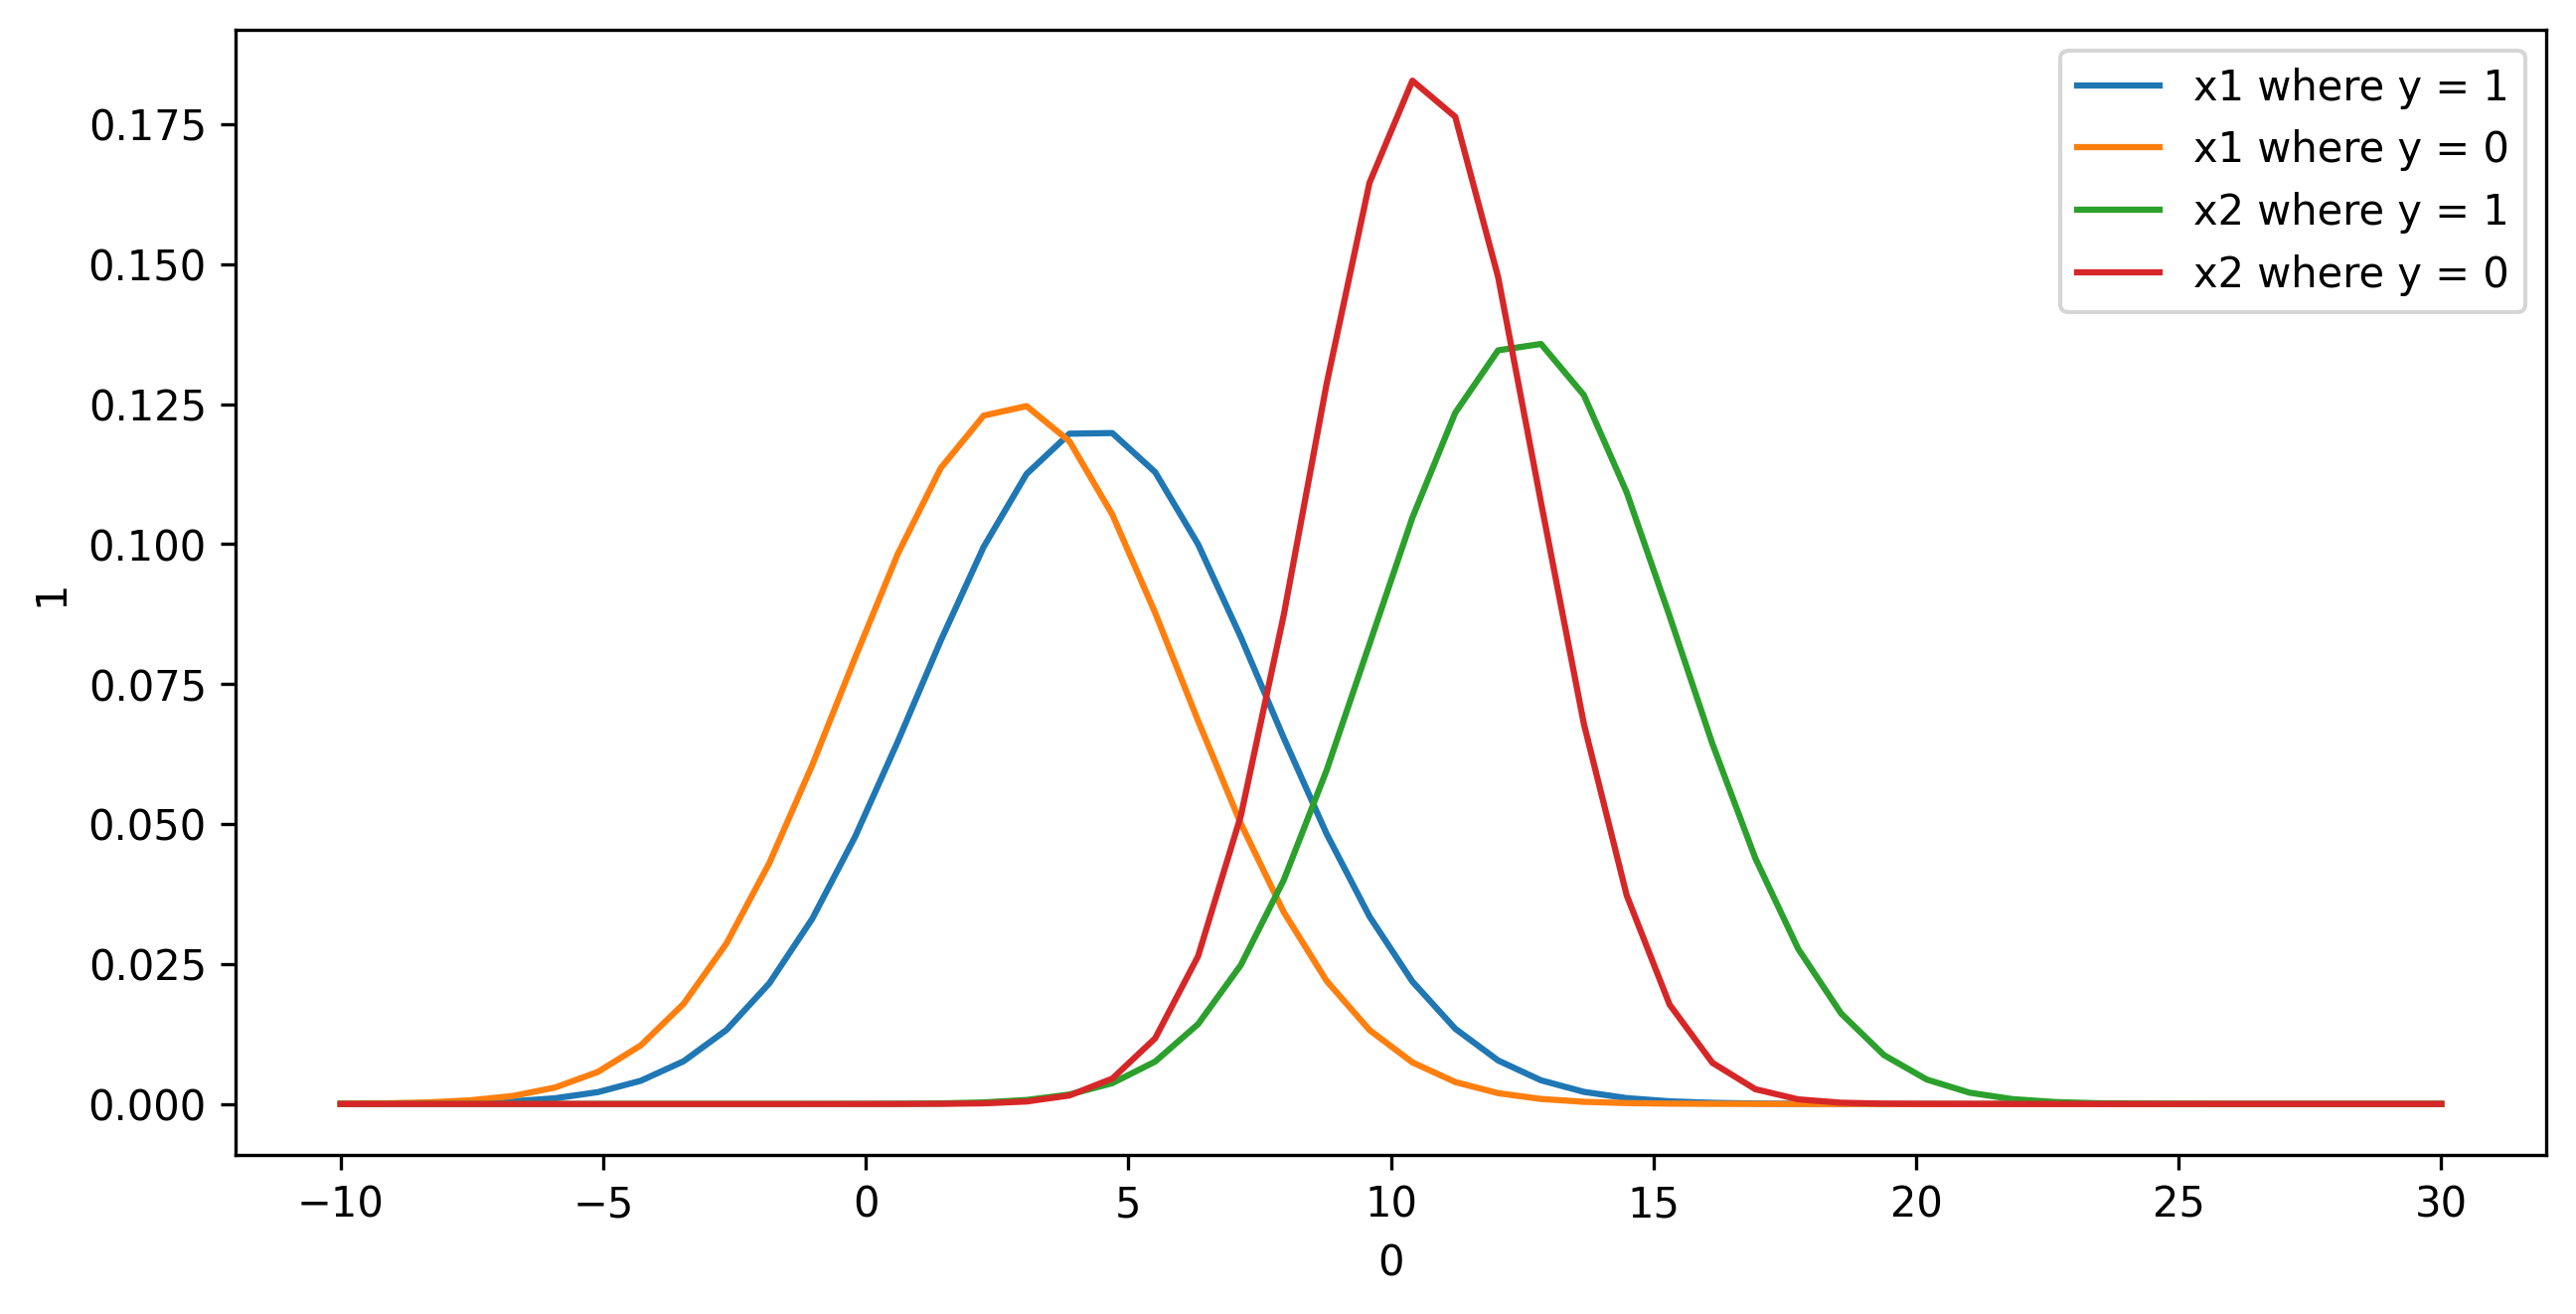

In [33]:
# Plot with seaborn
plt.figure(figsize=(10,5),dpi=300)
for key in dist_locs.keys():
    locs = dist_locs[key]
    d = pd.DataFrame([[i,st.norm(locs['mean'], locs['sd']).pdf(i)] 
                      for i in np.linspace(-10,30)])
    ax = sns.lineplot(d[0],d[1],label=f"{key[0]} where y = {key[1]}")

Prediction

In [21]:
# Prediction for the 1 class
a = st.norm(dist_locs[("x1",1)]['mean'], dist_locs[("x1",1)]['sd']).pdf(x1)
b = st.norm(dist_locs[("x2",1)]['mean'], dist_locs[("x2",1)]['sd']).pdf(x2)
c = pr_y1
pr_1 = a * b * c

# Prediction for the 0 class
a = st.norm(dist_locs[("x1",0)]['mean'], dist_locs[("x1",0)]['sd']).pdf(x1)
b = st.norm(dist_locs[("x2",0)]['mean'], dist_locs[("x2",0)]['sd']).pdf(x2)
c = pr_y0
pr_0 = a * b * c

print(
f'''
    Pr(y == 1| X): {pr_1}
    Pr(y == 0| X): {pr_0}
''')


    Pr(y == 1| X): 3.0419766247408258e-05
    Pr(y == 0| X): 3.435872752628962e-06



In [22]:
def predict(data,dist_locs):
    ''''''
    store_preds = []
    for i,row in data.iterrows():
        
        # Get the predictions using a Gaussan distribution
        pr_0 = 1; pr_1 = 1
        for j in range(1,len(row)):
            pr_0 *= st.norm(dist_locs[(row.index[j],0)]['mean'],
                            dist_locs[(row.index[j],0)]['sd']).pdf(row.values[j])
            pr_1 *= st.norm(dist_locs[(row.index[j],1)]['mean'], 
                            dist_locs[(row.index[j],1)]['sd']).pdf(row.values[j])
        pr_0 *= pr_y0
        pr_1 *= pr_y1
        
        # Assign the class designation to the highest probability
        if pr_0 >= pr_1:
            class_pred = 0
        else:
            class_pred = 1
            
        store_preds.append([pr_0,pr_1,class_pred])
        
    return pd.DataFrame(store_preds,columns=["pr_0","pr_1","pred"])

# Run
preds_train = predict(train_drop,dist_locs)

In [23]:
#  Predicted output
preds_train.head(10)

,pr_0,pr_1,pred
0,2.462405e-05,1.675137e-04,1
1,3.435873e-06,3.041977e-05,1
2,4.299211e-10,4.912871e-08,1
3,3.769874e-07,6.948193e-06,1
4,2.335046e-08,7.291342e-07,1
5,3.502145e-05,1.961120e-04,1
6,1.717783e-06,1.433831e-05,1
7,1.693573e-09,1.596995e-07,1
8,6.112578e-06,4.881506e-05,1
9,6.152428e-05,3.415893e-04,1


Determine the predictive accuracy of the training data.

In [24]:
accuracy_train = sum(train_drop.y == preds_train.pred)/train.shape[0]
accuracy_train

0.75125

Determine the predictive accuracy of the test data

In [25]:
# Test test df 
preds_test = predict(test_drop, dist_locs)

# Predictive accuracy of test data 
accuracy_train = sum(test_drop.y == preds_test.pred)/test_drop.shape[0]
accuracy_train

0.7

Based on the continuous variables age and income the model above was able to predict if someone was going to vote or not with ~75% accuracy on the training data and ~70% accuracy on the test data. 

The results are definitely not perfect, but the prediction is bettwe than a coinflip. The model is not overfit on the test data either because the accuracy across test and train were near each other. 